# Sports Betting Model using Random Forests

The sports betting market is established by sportsbooks, which set prices for certain assets that pay out if an outcome in an athletic contest occurs. Sportsbooks attempt to set prices to reflect true probabilities, but they also may consider revenue maximization. Players can potentially identify mispriced bets by modelling outcomes, and betting when they detect substantial differences between the perceived "actuarially fair," price, and the price given to them by sportsbooks. I try to use a random forest model to predict when one should bet a certain way on the "over/under," or total points scored by either team in a Major League Baseball contest.

In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn import tree
from IPython.display import Image
import pydotplus
import graphviz
import warnings

warnings.filterwarnings('ignore')

odds = pd.read_csv('mlb odds 2019.csv')

odds.head()

,Date,Rot,VH,Team,Pitcher,1st,2nd,3rd,4th,5th,...,9th,Final,Open,Close,Run Line,Unnamed: 18,Open OU,Unnamed: 20,Close OU,Unnamed: 22
0,320,901,N,SEA,MGONZALES-L,0,0,5,1,3,...,0,9,107,120,1.5,-160,8.5,-110,8.5,-120
1,320,902,N,OAK,MFIERS-R,1,1,2,0,0,...,0,7,-127,-130,-1.5,140,8.5,-110,8.5,100
2,321,903,N,SEA,YKIKUCHI-L,0,2,1,0,0,...,0,5,109,-125,1.5,-262,9.0,-110,9.0,-130
3,321,904,N,OAK,MESTRADA-R,0,0,0,0,2,...,0,4,-129,115,-1.5,216,9.0,-110,9.0,110
4,328,905,V,NYM,JDEGROM-R,1,0,0,0,0,...,0,2,110,115,1.5,-215,6.5,-110,6.5,-105


In [136]:
odds['Game ID'] = odds.index // 2

In [138]:
odds['Score'] = odds.apply(lambda x: odds[odds['Game ID'] == x['Game ID']]['Final'].sum(), axis=1)
odds['Over_open'] = odds['Score'] > odds['Open OU']
odds['Over_close'] = odds['Score'] > odds['Close OU']
odds['Push_open'] = odds['Score'] == odds['Open OU']
odds['Push_close'] = odds['Score'] == odds['Close OU']
odds['Under_open'] = odds['Score'] < odds['Open OU']
odds['Under_close'] = odds['Score'] < odds['Close OU']


In [139]:
odds['Under_open'].mean()

0.4724025974025974

In [140]:
odds['Avg_runs'] = odds.apply(lambda x: odds[(odds.Team == x.Team) & (odds.Date < x.Date)]['Final'].mean(), axis=1)

In [141]:
odds['Runs_against'] = odds.apply(lambda x: odds[(odds['Game ID'] == x['Game ID']) & (odds.Team != x.Team)].iloc[0,14], axis=1)

In [142]:
odds['Avg_runs_pitcher'] = odds.apply(lambda x: odds[(odds.Pitcher == x.Pitcher) & (odds.Date < x.Date)]['Runs_against'].mean(), axis=1)

In [143]:
# From our raw dataset, we create a new data frame with each game as a single line (the previous DF 
# included a line for each team, creating two lines for each game)

games = pd.DataFrame(columns=['Game ID'])
games['Game ID'] = odds['Game ID'].unique()
games = pd.merge(games, odds[['Game ID', 'Open OU', 'Close OU', 'Score', 'Over_open', 'Over_close', 'Push_open', 'Push_close', 'Under_open', 'Under_close']], how='inner', on='Game ID')
games = games.groupby(['Game ID'])[['Open OU', 'Close OU', 'Score', 'Over_open', 'Over_close', 'Push_open', 'Push_close', 'Under_open', 'Under_close']].min().reset_index()
games = pd.merge(games, odds.groupby(['Game ID'])['Avg_runs'].sum(), on='Game ID')
games = pd.merge(games, odds.groupby(['Game ID'])['Avg_runs_pitcher'].sum(), on='Game ID')


In [144]:
# Remove games without information on previous pitcher performance (likely the first few games of the season)
games = games[games.Avg_runs_pitcher != 0]

In [145]:
games['Avg_runs_minus_open'] = games['Avg_runs'] - games['Open OU']
games['Avg_runs_p_minus_open'] = games['Avg_runs_pitcher'] - games['Open OU']

In [146]:
games.columns
games['Game ID'].describe()

count    2395.000000
mean     1264.562004
std       693.190819
min        12.000000
25%       664.500000
50%      1266.000000
75%      1864.500000
max      2463.000000
Name: Game ID, dtype: float64

In [147]:
X = games[['Game ID', 'Open OU', 'Avg_runs', 'Avg_runs_pitcher', 'Avg_runs_minus_open', 'Avg_runs_p_minus_open']]
y = games['Over_open']
X_train = X[X['Game ID'] <= 1800][['Open OU', 'Avg_runs', 'Avg_runs_pitcher', 'Avg_runs_minus_open', 'Avg_runs_p_minus_open']]
y_train = y[X['Game ID'] <= 1800]
X_test = X[X['Game ID'] > 1800][['Open OU', 'Avg_runs', 'Avg_runs_pitcher', 'Avg_runs_minus_open', 'Avg_runs_p_minus_open']]
y_test = y[X['Game ID'] > 1800]

# Decision Tree

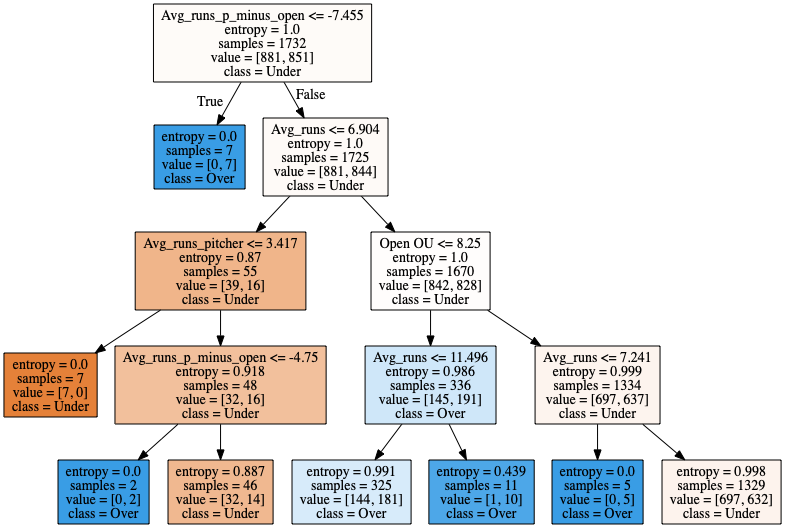

In [148]:
# Initialize and train our tree.
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=5,
    max_depth=4,
)
decision_tree.fit(X_train, y_train)

# Render our tree.
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=X_train.columns,
    class_names=['Under', 'Over'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [149]:
rfc = ensemble.RandomForestClassifier(max_depth=3, max_features=3)
scores = cross_val_score(rfc, X_train, y_train, cv=10)
print('Mean: \t\t\t{}'.format(scores.mean()))
print('Standard Deviation: \t{}'.format(scores.std()))

Mean: 			0.5010668868703549
Standard Deviation: 	0.031342990478493774


In [150]:
rfc.fit(X_train, y_train)

print('---------- Feature Importance ----------')

for f in range(X_train.shape[1]):
    print('{}:'.format(X_train.columns[f])+' '*(20-len(X_train.columns[f]))+'\t{}'.format(rfc.feature_importances_[f]))

---------- Feature Importance ----------
Open OU:             	0.05818315424860574
Avg_runs:            	0.30428037415855724
Avg_runs_pitcher:    	0.26322467954826856
Avg_runs_minus_open: 	0.10645696651470957
Avg_runs_p_minus_open:	0.26785482552985895


In [151]:
test_push = games[games['Game ID'] > 1800]['Push_open']

In [152]:
success = y_test[rfc.predict(X_test)]
push = test_push[rfc.predict(X_test)]

In [153]:
# After removing "pushes," where the score result is exactly the over-under, and bets are refunded, we get
# the following success rate. We need approximately 53% to make a profit.
success.mean()/(1 - push.mean() - success.mean() + success.mean())

0.5181818181818182

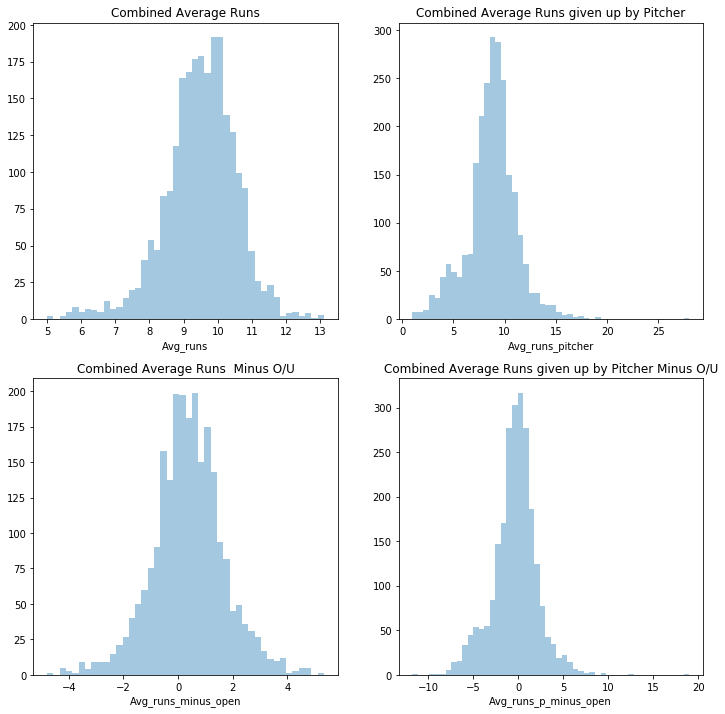

In [154]:
# Not very impressive. Let's explore our features a little.

plt.figure(figsize=(12,12))

plt.subplot(2,2,1)
sns.distplot(games['Avg_runs'], kde=False)
plt.title('Combined Average Runs')

plt.subplot(2,2,2)
sns.distplot(games['Avg_runs_pitcher'], kde=False)
plt.title('Combined Average Runs given up by Pitcher')

plt.subplot(2,2,3)
sns.distplot(games['Avg_runs_minus_open'], kde=False)
plt.title('Combined Average Runs  Minus O/U')

plt.subplot(2,2,4)
sns.distplot(games['Avg_runs_p_minus_open'], kde=False)
plt.title('Combined Average Runs given up by Pitcher Minus O/U')
plt.show()

In [155]:
games['bin 1'] = (games['Avg_runs_minus_open'] // 1) + .5
games['bin 2'] = (games['Avg_runs_p_minus_open'] // 2)* 2 + 1


In [156]:
run_min_ou = games.groupby(['bin 1'])[['Over_open', 'Push_open', 'Under_open']].mean()
run_min_ou['ov_edge'] = run_min_ou['Over_open']/(run_min_ou['Under_open']+run_min_ou['Over_open'])
run_min_ou['un_edge'] = run_min_ou['Under_open']/(run_min_ou['Over_open']+run_min_ou['Under_open'])
#run_min_ou['bin 1'] = run_min_ou['bin 1'] + 0.5
run_min_ou = pd.merge(run_min_ou, games.groupby(['bin 1'])['Game ID'].count(), on='bin 1')
run_min_ou = run_min_ou.rename(columns={'Game ID': 'Sample Size'})

run_min_ou

,Over_open,Push_open,Under_open,ov_edge,un_edge,Sample Size
bin 1,,,,,,
-4.5,0.444444,0.111111,0.444444,0.500000,0.500000,9
-3.5,0.450000,0.050000,0.500000,0.473684,0.526316,20
-2.5,0.393443,0.081967,0.524590,0.428571,0.571429,61
-1.5,0.461165,0.058252,0.480583,0.489691,0.510309,206
-0.5,0.475548,0.045531,0.478921,0.498233,0.501767,593
0.5,0.466667,0.054088,0.479245,0.493351,0.506649,795
1.5,0.473029,0.045643,0.481328,0.495652,0.504348,482
2.5,0.555556,0.043210,0.401235,0.580645,0.419355,162
3.5,0.547170,0.075472,0.377358,0.591837,0.408163,53


In [157]:
prun_min_ou = games.groupby(['bin 2'])[['Over_open', 'Push_open', 'Under_open']].mean()
prun_min_ou['ov_edge'] = prun_min_ou['Over_open']/(prun_min_ou['Under_open']+prun_min_ou['Over_open'])
prun_min_ou['un_edge'] = prun_min_ou['Under_open']/(prun_min_ou['Over_open']+prun_min_ou['Under_open'])
#run_min_ou['bin 1'] = run_min_ou['bin 1'] + 0.5
prun_min_ou = pd.merge(prun_min_ou, games.groupby(['bin 2'])['Game ID'].count(), on='bin 2')
prun_min_ou = prun_min_ou.rename(columns={'Game ID': 'Sample Size'})

prun_min_ou

,Over_open,Push_open,Under_open,ov_edge,un_edge,Sample Size
bin 2,,,,,,
-11.0,1.000000,0.000000,0.000000,1.000000,0.000000,1
-9.0,1.000000,0.000000,0.000000,1.000000,0.000000,3
-7.0,0.476190,0.000000,0.523810,0.476190,0.523810,42
-5.0,0.487179,0.032051,0.480769,0.503311,0.496689,156
-3.0,0.465201,0.069597,0.465201,0.500000,0.500000,273
-1.0,0.455901,0.047205,0.496894,0.478488,0.521512,805
1.0,0.482500,0.055000,0.462500,0.510582,0.489418,800
3.0,0.548673,0.039823,0.411504,0.571429,0.428571,226
5.0,0.433333,0.066667,0.500000,0.464286,0.535714,60


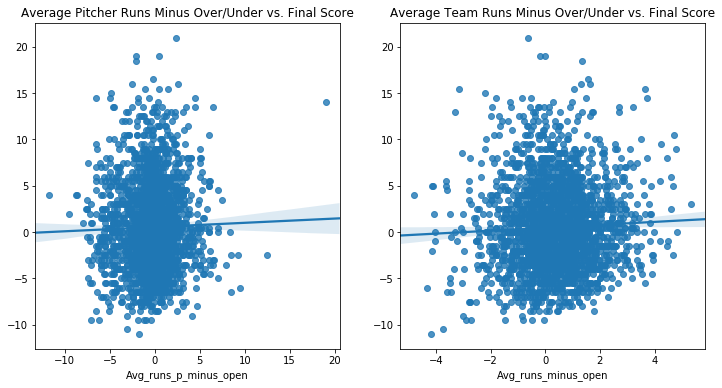

In [158]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title('Average Pitcher Runs Minus Over/Under vs. Final Score')
sns.regplot(games['Avg_runs_p_minus_open'], games['Score'] - games['Open OU'])

plt.subplot(1,2,2)
plt.title('Average Team Runs Minus Over/Under vs. Final Score')
sns.regplot(games['Avg_runs_minus_open'], games['Score'] - games['Open OU'])

plt.show()

It looks like average runs scored is fairly predictive of a mispriced over/under, so much so that there is enough difference to have a profitable edge if the difference is above 2 or so. It doesn't appear that average runs given up by a pitcher is indicative of likelihood of 

When we look at the scatter plots, it doesn't look like either is terribly predictive, but outside of the \[-2,2\] interval in the graph on the right, it does appear that there is some level of predictability.

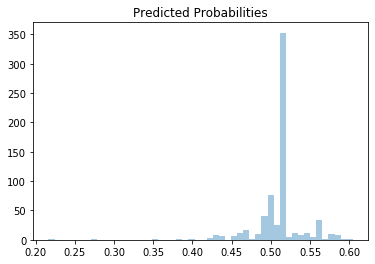

In [159]:
plt.title('Predicted Probabilities')
sns.distplot([x[0] for x in rfc.predict_proba(X_test)], kde=False)
plt.show()


In [160]:
y_test[([x[0] < .5 for x in rfc.predict_proba(X_test)])].mean()

0.49137931034482757

Exploring various cutoffs did not seem to produce anything with reliable predictive power. It's possible that a random forest isn't terribly well-suited to this problem, and something more deterministic (ie a linear regression predicting score for each team) may be more effective.